# Estimating a mixed Gaussian distribution

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from dpmmlearn import DPMM
from dpmmlearn.probability import GaussianMeanKnownVariance, NormInvChi2, NormInvGamma

## Prepare data

In [2]:
def gaussian_sample(mu_list, var_list, size, portion, random_seed=0):
    np.random.seed(random_seed)
    nums = np.random.multinomial(size, portion)
    xs = []
    for mu, var, num in zip(mu_list, var_list, nums):
        x = np.random.normal(loc=mu, scale=np.sqrt(var), size=num)
        xs.append(x)
    xs = np.concatenate(xs)
    return xs


def sample_pdf(x, mu_list, var_list, portion):
    y = np.zeros_like(x)
    for mu, var, num in zip(mu_list, var_list, portion):
        y_ = np.exp(-0.5*(x-mu)**2/var)/np.sqrt(2*np.pi*var)
        y += num/sum(portion) * y_
    return y


def result_pdf(x, thetas, n_labels, sigsqr):
    y = np.zeros_like(x)
    for theta, n_label in zip(thetas, n_labels):
        mu = theta
        y_ = np.exp(-0.5*(x-mu)**2/sigsqr)/np.sqrt(2*np.pi*sigsqr)
        y += n_label/sum(n_labels) * y_
    return y

In [3]:
size = 400
mu_list = [-0.5, 0.0, 0.7]  # means
var_list = [0.02, 0.03, 0.1]  # variances
portion = [0.25, 0.4, 0.35]  # proportions


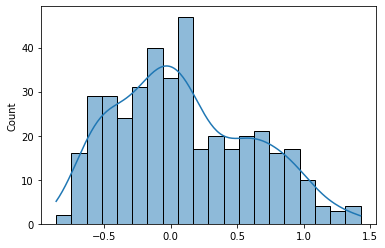

In [4]:
X = gaussian_sample(mu_list, var_list, size, portion)
sns.histplot(X, bins=20,kde=True)
plt.show()

## known variance model

we'll infer a Gaussian mixture model where the components all have known variance but unknown means.

In [5]:
mu_0 = 0.0
sigsqr_0 = 1.0
sigsqr = 0.05
prob = GaussianMeanKnownVariance(mu_0, sigsqr_0, sigsqr)
alpha = 0.1

model = DPMM(prob, alpha, max_iter=100)
model.fit(X)

iter=init -- New label created: 0
iter=init -- New label created: 1
iter=init -- New label created: 2
iter=5 -- New label created: 3
iter=5 -- New label created: 4
iter=6 -- Label deleted: 3
iter=9 -- New label created: 4
iter=10 -- Label deleted: 3
iter=11 -- Label deleted: 3
iter=18 -- New label created: 3
iter=20 -- Label deleted: 3
========== Finished! ==========
best_iter=58 -- n_labels: 3


DPMM(alpha=0.1, max_iter=100,
     prob=GaussianMeanKnownVariance(mu_0=0.0, sigsqr_0=1.0, sigsqr=0.05))

In [6]:
print(mu_list, portion)
print(model.thetas_, [k/sum(model.n_labels_) for k in model.n_labels_])

[-0.5, 0.0, 0.7] [0.25, 0.4, 0.35]
[0.050030334193958095, -0.5077112955444281, 0.7687125490383199] [0.485, 0.245, 0.27]


In [7]:
x = np.arange(-2, 2, 0.01)
y_true = sample_pdf(x, mu_list, var_list, portion)
y_pred = result_pdf(x, model.thetas_, model.n_labels_, sigsqr)

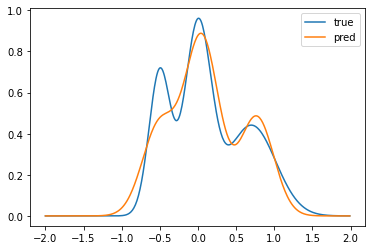

In [8]:
plt.plot(x, y_true, label='true')
plt.plot(x, y_pred, label='pred')
plt.legend()
plt.show()

## Modeling mean and variance

Letting the component means to float, let the component variances also float.

In [9]:
mu_0 = 0.3
kappa_0 = 0.1
sigsqr_0 = 0.1
nu_0 = 1.0
prob = NormInvChi2(mu_0, kappa_0, sigsqr_0, nu_0)
alpha = 1.0

model2 = DPMM(prob, alpha, max_iter=500)
model2.fit(X)

iter=init -- New label created: 0
iter=init -- New label created: 1
iter=init -- New label created: 2
iter=init -- New label created: 3
iter=init -- New label created: 4
iter=init -- New label created: 5
iter=init -- New label created: 6
iter=1 -- New label created: 7
iter=1 -- New label created: 8
iter=2 -- Label deleted: 6
iter=2 -- New label created: 8
iter=3 -- New label created: 9
iter=4 -- New label created: 10
iter=4 -- New label created: 11
iter=5 -- Label deleted: 11
iter=7 -- Label deleted: 10
iter=8 -- New label created: 10
iter=9 -- Label deleted: 7
iter=9 -- Label deleted: 9
iter=10 -- Label deleted: 5
iter=10 -- Label deleted: 5
iter=11 -- New label created: 7
iter=12 -- New label created: 8
iter=12 -- Label deleted: 6
iter=12 -- Label deleted: 6
iter=13 -- Label deleted: 2
iter=13 -- New label created: 6
iter=13 -- Label deleted: 5
iter=14 -- Label deleted: 5
iter=14 -- Label deleted: 4
iter=15 -- New label created: 4
iter=17 -- New label created: 5
iter=17 -- New label 

DPMM(alpha=1.0, prob=NormInvChi2(mu_0=0.3, kappa_0=0.1, sigsqr_0=0.1, nu_0=1.0))

In [10]:
print(list(zip(mu_list, var_list)), portion)
print(model2.thetas_, [k/sum(model2.n_labels_) for k in model2.n_labels_])

[(-0.5, 0.02), (0.0, 0.03), (0.7, 0.1)] [0.25, 0.4, 0.35]
[(-0.17253015, 0.1073423), (-0.38286569, 0.06882894), (0.74585894, 0.06611424)] [0.7125, 0.005, 0.2825]


In [11]:
mu_ = [mu for mu, var in model2.thetas_]
var_ = [var for mu, var in model2.thetas_]
portion_ = [k/sum(model2.n_labels_) for k in model2.n_labels_]

y_pred = sample_pdf(x, mu_, var_, portion_)

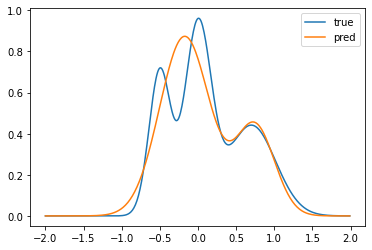

In [12]:
plt.plot(x, y_true, label='true')
plt.plot(x, y_pred, label='pred')
plt.legend()
plt.show()

## Normal-inverse-Gamm Prior

Should be able to get statistically identical results from a NIG prior with corresponding hyperparameters.

In [13]:
m_0 = mu_0
V_0 = 1. / kappa_0
a_0 = nu_0 / 2.0
b_0 = nu_0 * sigsqr_0 / 2.0
prob = NormInvGamma(m_0, V_0, a_0, b_0)
alpha = 1.0

model3 = DPMM(prob, alpha, max_iter=100)
model3.fit(X)

iter=init -- New label created: 0
iter=init -- New label created: 1
iter=init -- New label created: 2
iter=init -- New label created: 3
iter=init -- New label created: 4
iter=init -- New label created: 5
iter=init -- New label created: 6
iter=1 -- New label created: 7
iter=1 -- New label created: 8
iter=2 -- Label deleted: 6
iter=2 -- New label created: 8
iter=3 -- New label created: 9
iter=4 -- New label created: 10
iter=4 -- New label created: 11
iter=5 -- Label deleted: 11
iter=7 -- Label deleted: 10
iter=8 -- New label created: 10
iter=9 -- Label deleted: 7
iter=9 -- Label deleted: 9
iter=10 -- Label deleted: 5
iter=10 -- Label deleted: 5
iter=11 -- New label created: 7
iter=12 -- New label created: 8
iter=12 -- Label deleted: 6
iter=12 -- Label deleted: 6
iter=13 -- Label deleted: 2
iter=13 -- New label created: 6
iter=13 -- Label deleted: 5
iter=14 -- Label deleted: 5
iter=14 -- Label deleted: 4
iter=15 -- New label created: 4
iter=17 -- New label created: 5
iter=17 -- New label 

DPMM(alpha=1.0, max_iter=100,
     prob=NormInvGamma(m_0=0.3, V_0=10.0, a_0=0.5, b_0=0.05))

In [14]:
print(list(zip(mu_list, var_list)), portion)
print(model3.thetas_, [k/sum(model3.n_labels_) for k in model3.n_labels_])

[(-0.5, 0.02), (0.0, 0.03), (0.7, 0.1)] [0.25, 0.4, 0.35]
[(-0.17253015, 0.1073423), (-0.38286569, 0.06882894), (0.74585894, 0.06611424)] [0.7125, 0.005, 0.2825]


In [15]:
mu_ = [mu for mu, var in model2.thetas_]
var_ = [var for mu, var in model2.thetas_]
portion_ = [k/sum(model2.n_labels_) for k in model2.n_labels_]

y_pred = sample_pdf(x, mu_, var_, portion_)

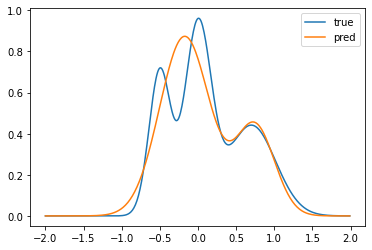

In [16]:
plt.plot(x, y_true, label='true')
plt.plot(x, y_pred, label='pred')
plt.legend()
plt.show()